<a href="https://colab.research.google.com/github/ttderessa/Temesgen-Deressa/blob/main/Lane_Keeping_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🚗 Starting Lane-Keeping Assistant Demo
🎬 Generating synthetic road video...
✅ Synthetic road video created: synthetic_road.mp4

🔍 Processing video frames...
  Processed frame 20
  Processed frame 40
  Processed frame 60
  Processed frame 80
  Processed frame 100
✅ Processed 100 frames total

💾 Saving processed video...
✅ Output saved: lane_keeping_output.mp4

📊 Generating analysis plots...


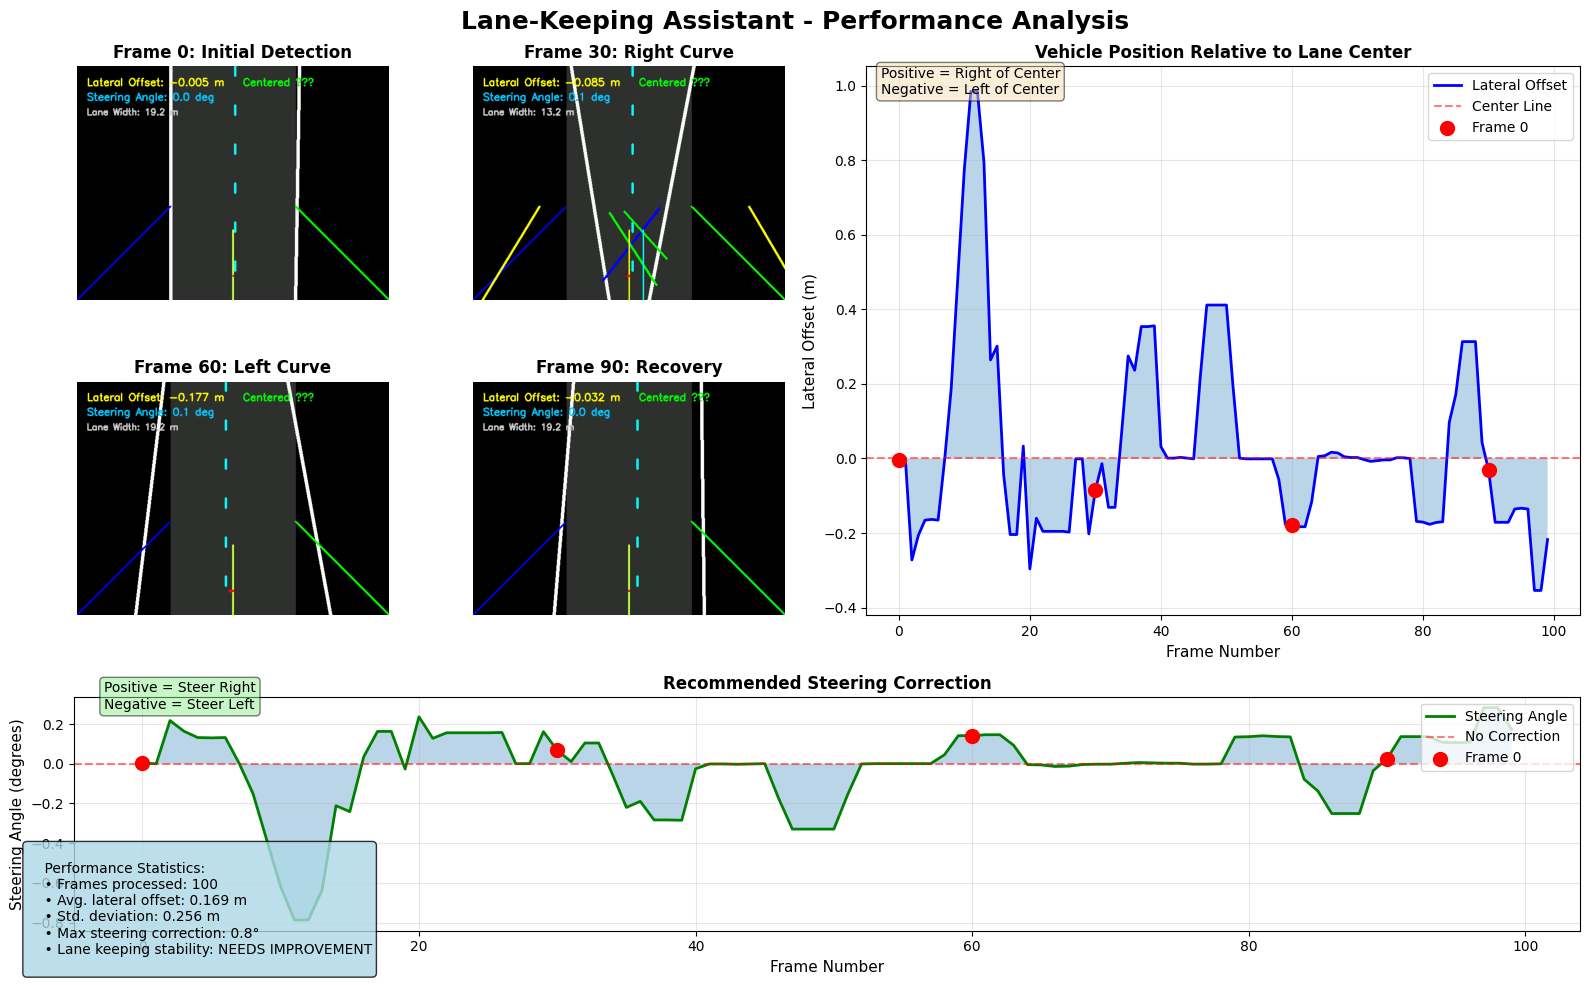


📈 Analysis complete! Key insights:
   • Average lateral offset: 0.169 m
   • Maximum steering correction: 0.8°
   • Lane keeping stability: Needs improvement

🎞️  Displaying key processed frames...


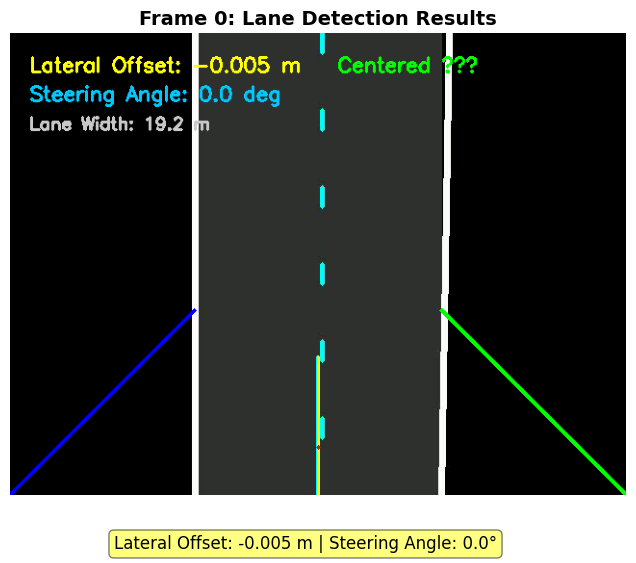

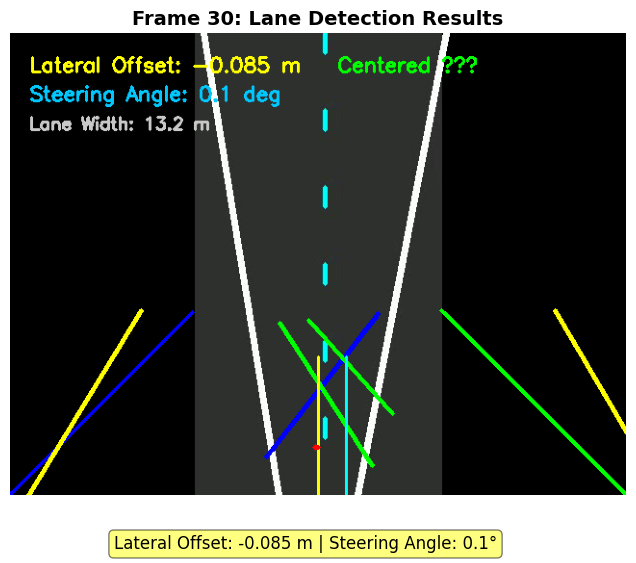

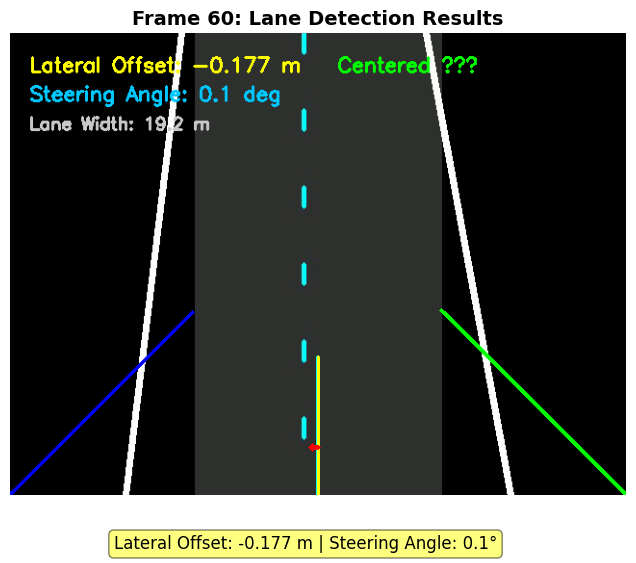

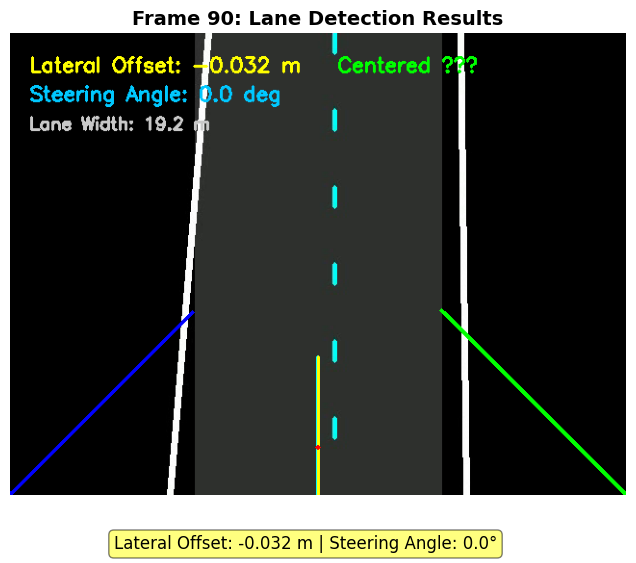


⬇️  Ready for download:
   • synthetic_road.mp4 (Input video)
   • lane_keeping_output.mp4 (Processed video)
   • performance_analysis.png (Analysis plots)

🎉 Demo Complete!

What you've accomplished:
1. ✅ Generated a synthetic road with dynamic lanes
2. ✅ Implemented complete computer vision pipeline
3. ✅ Detected and tracked lane lines in real-time
4. ✅ Calculated vehicle position and steering corrections
5. ✅ Visualized all processing steps

Try modifying these parameters to experiment:
   • LaneKeepingAssistant(kp=0.5) - Gentler steering
   • LaneKeepingAssistant(kp=1.2) - More aggressive steering
   • Adjust max_steering_angle for different vehicle types


In [2]:
'''
Author: Dr. Temesgen Deressa
Date: December 2, 2024
This tutorial is intended for educational purposes only.
I welcome your feedback and comments at ttderessa@gmail.com
'''

# ==========================================================
# Synthetic Lane-Keeping Demo - Complete Colab Implementation
# =========================================================
# Features:
# 1. Generates synthetic road video with dynamic lanes
# 2. Detects lanes using Canny edge detection + Hough Transform
# 3. Calculates lateral offset from lane center
# 4. Computes steering angle using PID-like control
# 5. Visualizes all processing steps in real-time
# =========================================================

# Install required packages
!pip install opencv-python matplotlib -q

import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# ==================== PART 1: SYNTHETIC ROAD GENERATION ====================

def generate_synthetic_road(video_path='synthetic_road.mp4',
                           width=640, height=480, num_frames=100):
    """
    Create a synthetic road video with dynamic lane lines
    Simulates gentle curves and camera perspective
    """
    print("🎬 Generating synthetic road video...")

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(video_path, fourcc, 20, (width, height))

    for i in range(num_frames):
        # Create black background
        frame = np.zeros((height, width, 3), dtype=np.uint8)

        # Draw road surface (gray rectangle)
        road_width = int(width * 0.4)
        road_left = int(width * 0.3)
        cv2.rectangle(frame, (road_left, 0), (road_left + road_width, height),
                     (50, 50, 50), -1)

        # Add perspective effect: lanes get narrower at the top
        perspective_factor = 0.2 * np.sin(i/15)  # Dynamic perspective

        # Calculate lane positions with gentle curves
        base_shift = int(25 * np.sin(i/12))  # Simulates car weaving
        left_lane_start = road_left + base_shift + int(10 * np.sin(i/8))
        left_lane_end = road_left + int(perspective_factor * height)

        right_lane_start = road_left + road_width + base_shift + int(10 * np.sin(i/8 + 1))
        right_lane_end = road_left + road_width - int(perspective_factor * height)

        # Draw lane lines
        cv2.line(frame, (left_lane_start, 0), (left_lane_end, height),
                (255, 255, 255), 6)  # Left lane - thicker
        cv2.line(frame, (right_lane_start, 0), (right_lane_end, height),
                (255, 255, 255), 6)  # Right lane

        # Add dashed center line for visual reference
        for y in range(0, height, 40):
            if (y // 40) % 2 == 0:
                center_x = (left_lane_start + right_lane_start) // 2
                cv2.line(frame, (center_x, y), (center_x, y + 20),
                        (255, 255, 0), 3)

        out.write(frame)

    out.release()
    print(f"✅ Synthetic road video created: {video_path}")
    return video_path

# ==================== PART 2: LANE KEEPING PIPELINE ====================

class LaneKeepingAssistant:
    """
    Complete lane detection and steering calculation pipeline
    Implements computer vision techniques used in real ADAS systems
    """

    def __init__(self, kp=0.7, max_steering_angle=30, pixels_per_meter=50):
        """
        Initialize lane keeping parameters

        Parameters:
        - kp: Proportional gain for steering control (higher = more aggressive correction)
        - max_steering_angle: Maximum steering angle in degrees
        - pixels_per_meter: Conversion factor from pixels to real-world meters
        """
        self.kp = kp
        self.max_steering_angle = max_steering_angle
        self.pixels_per_meter = pixels_per_meter
        self.frame_history = []  # For smoothing detections

    def preprocess_frame(self, frame):
        """Convert to grayscale and enhance contrast"""
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        # Apply CLAHE for better contrast
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        enhanced = clahe.apply(gray)
        return enhanced

    def region_of_interest(self, img, vertices_ratio=0.6):
        """
        Focus on the lower portion of the image where lanes are visible
        This eliminates sky and distant objects
        """
        height, width = img.shape
        mask = np.zeros_like(img)

        # Define trapezoid region (approximates road perspective)
        vertices = np.array([[
            (0, height),
            (width, height),
            (int(width * 0.7), int(height * vertices_ratio)),
            (int(width * 0.3), int(height * vertices_ratio))
        ]], np.int32)

        cv2.fillPoly(mask, vertices, 255)
        masked = cv2.bitwise_and(img, mask)
        return masked

    def detect_edges(self, gray_frame):
        """Canny edge detection with dynamic thresholds"""
        # Calculate median pixel intensity for adaptive thresholds
        median_intensity = np.median(gray_frame)
        lower = int(max(0, 0.7 * median_intensity))
        upper = int(min(255, 1.3 * median_intensity))

        edges = cv2.Canny(gray_frame, lower, upper)
        return edges

    def detect_lane_lines(self, edges):
        """
        Detect lines using Hough Transform
        Returns list of lines in format [[x1, y1, x2, y2], ...]
        """
        lines = cv2.HoughLinesP(
            edges,
            rho=1,
            theta=np.pi/180,
            threshold=30,
            minLineLength=50,
            maxLineGap=100
        )

        return [] if lines is None else lines

    def filter_and_cluster_lines(self, lines, frame_width):
        """
        Separate lines into left and right lanes
        Filters out unrealistic slopes and clusters similar lines
        """
        left_lines = []
        right_lines = []

        if lines is None or len(lines) == 0:
            return left_lines, right_lines

        for line in lines:
            x1, y1, x2, y2 = line[0]

            # Skip near-vertical lines (avoid division by zero)
            if abs(x2 - x1) < 1:
                continue

            slope = (y2 - y1) / (x2 - x1)

            # Filter horizontal lines and extreme slopes
            if abs(slope) < 0.3 or abs(slope) > 2.0:
                continue

            # Calculate line length
            length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

            # Left lanes have negative slope (go down-right), right lanes positive
            if slope < 0 and x1 < frame_width * 0.6 and x2 < frame_width * 0.6:
                left_lines.append((slope, length, line))
            elif slope > 0 and x1 > frame_width * 0.4 and x2 > frame_width * 0.4:
                right_lines.append((slope, length, line))

        return left_lines, right_lines

    def calculate_lane_parameters(self, lines, frame_width, side='left'):
        """
        Calculate single lane line from multiple detected segments
        Uses RANSAC-like approach for robustness
        """
        if len(lines) == 0:
            # Return default lane position if no lines detected
            return (frame_width * 0.25 if side == 'left' else frame_width * 0.75, 0)

        # Weight lines by their length (longer lines are more reliable)
        total_weight = sum(length for _, length, _ in lines)
        if total_weight == 0:
            return (frame_width * 0.25 if side == 'left' else frame_width * 0.75, 0)

        # Calculate weighted average slope and intercept
        avg_slope = sum(slope * length for slope, length, _ in lines) / total_weight

        # Calculate average x position at bottom of frame
        x_positions = []
        for _, length, line in lines:
            x1, y1, x2, y2 = line[0]
            # Extrapolate to bottom of frame
            slope = (y2 - y1) / (x2 - x1) if (x2 - x1) != 0 else 0.001
            intercept = y1 - slope * x1
            x_at_bottom = (frame_width - intercept) / slope if slope != 0 else x1
            x_positions.append(x_at_bottom)

        avg_x = np.mean(x_positions)
        return (avg_x, avg_slope)

    def calculate_lateral_offset(self, left_lane_x, right_lane_x, frame_width):
        """
        Calculate how far the vehicle is from lane center
        Positive = right of center, Negative = left of center
        """
        lane_center = (left_lane_x + right_lane_x) / 2
        image_center = frame_width / 2

        # Convert pixels to meters
        offset_pixels = lane_center - image_center
        offset_meters = offset_pixels / self.pixels_per_meter

        # Apply simple low-pass filter for smoothing
        self.frame_history.append(offset_meters)
        if len(self.frame_history) > 5:
            self.frame_history.pop(0)

        return np.mean(self.frame_history)

    def calculate_steering_angle(self, lateral_offset):
        """
        PID-like steering control
        Simple proportional control for this demo
        """
        if lateral_offset is None:
            return 0

        # Steering angle = -Kp * error (negative for correct direction)
        steering_angle = -self.kp * lateral_offset

        # Clip to maximum steering angle
        steering_angle = np.clip(steering_angle,
                                -self.max_steering_angle,
                                self.max_steering_angle)

        return float(steering_angle)

    def process_frame(self, frame, visualize=True):
        """
        Complete pipeline for a single frame
        Returns processed frame and control outputs
        """
        height, width = frame.shape[:2]

        # Step 1: Preprocessing
        gray = self.preprocess_frame(frame)

        # Step 2: Region of Interest
        roi = self.region_of_interest(gray)

        # Step 3: Edge Detection
        edges = self.detect_edges(roi)

        # Step 4: Lane Detection
        raw_lines = self.detect_lane_lines(edges)

        # Step 5: Line Filtering and Clustering
        left_lines_data, right_lines_data = self.filter_and_cluster_lines(raw_lines, width)

        # Step 6: Calculate Lane Parameters
        left_x, left_slope = self.calculate_lane_parameters(left_lines_data, width, 'left')
        right_x, right_slope = self.calculate_lane_parameters(right_lines_data, width, 'right')

        # Step 7: Calculate Lateral Offset
        lateral_offset = self.calculate_lateral_offset(left_x, right_x, width)

        # Step 8: Calculate Steering Angle
        steering_angle = self.calculate_steering_angle(lateral_offset)

        # Visualization
        if visualize:
            # Draw detected lines
            for _, _, line in left_lines_data:
                x1, y1, x2, y2 = line[0]
                cv2.line(frame, (x1, y1), (x2, y2), (255, 0, 0), 3)
            for _, _, line in right_lines_data:
                x1, y1, x2, y2 = line[0]
                cv2.line(frame, (x1, y1), (x2, y2), (0, 255, 0), 3)

            # Draw lane boundaries
            lane_color = (0, 255, 255)
            cv2.line(frame, (int(left_x), height),
                    (int(left_x - 100 * left_slope), int(height * 0.6)),
                    lane_color, 3)
            cv2.line(frame, (int(right_x), height),
                    (int(right_x - 100 * right_slope), int(height * 0.6)),
                    lane_color, 3)

            # Draw lane center and vehicle position
            lane_center = int((left_x + right_x) / 2)
            cv2.line(frame, (lane_center, height), (lane_center, int(height * 0.7)),
                    (255, 255, 0), 2)
            cv2.line(frame, (width // 2, height), (width // 2, int(height * 0.7)),
                    (0, 255, 255), 2)

            # Draw offset indicator
            offset_pixels = int(lateral_offset * self.pixels_per_meter)
            cv2.arrowedLine(frame, (width // 2, height - 50),
                          (width // 2 + offset_pixels, height - 50),
                          (0, 0, 255), 3, tipLength=0.3)

            # Display metrics
            cv2.putText(frame, f'Lateral Offset: {lateral_offset:.3f} m',
                       (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)
            cv2.putText(frame, f'Steering Angle: {steering_angle:.1f} deg',
                       (20, 70), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 200, 0), 2)
            cv2.putText(frame, f'Lane Width: {abs(right_x - left_x)/self.pixels_per_meter:.1f} m',
                       (20, 100), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (200, 200, 200), 2)

            # Add color-coded steering suggestion
            if abs(steering_angle) > 15:
                steer_color = (0, 0, 255)  # Red for large correction
                steer_text = "CORRECT STEERING!"
            elif abs(steering_angle) > 5:
                steer_color = (0, 165, 255)  # Orange for medium correction
                steer_text = "Adjust steering"
            else:
                steer_color = (0, 255, 0)  # Green for centered
                steer_text = "Centered ✓"

            cv2.putText(frame, steer_text, (width - 300, 40),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, steer_color, 2)

        return frame, lateral_offset, steering_angle

# ==================== PART 3: MAIN EXECUTION ====================

def main():
    """Run the complete lane-keeping demo"""

    print("🚗 Starting Lane-Keeping Assistant Demo")
    print("=" * 50)

    # Step 1: Generate synthetic road
    video_path = generate_synthetic_road()

    # Step 2: Initialize lane keeper
    lane_keeper = LaneKeepingAssistant(kp=0.8, max_steering_angle=25)

    # Step 3: Process video
    print("\n🔍 Processing video frames...")
    cap = cv2.VideoCapture(video_path)
    processed_frames = []
    offsets = []
    steering_angles = []

    frame_idx = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Process frame
        processed_frame, offset, steering = lane_keeper.process_frame(frame, visualize=True)
        processed_frames.append(processed_frame)
        offsets.append(offset)
        steering_angles.append(steering)

        frame_idx += 1
        if frame_idx % 20 == 0:
            print(f"  Processed frame {frame_idx}")

    cap.release()
    print(f"✅ Processed {frame_idx} frames total")

    # Step 4: Save output video
    print("\n💾 Saving processed video...")
    height, width, _ = processed_frames[0].shape
    output_path = 'lane_keeping_output.mp4'
    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), 20, (width, height))

    for frame in processed_frames:
        out.write(frame)
    out.release()

    print(f"✅ Output saved: {output_path}")

    # Step 5: Create visualization - FIXED VERSION
    print("\n📊 Generating analysis plots...")

    # Create a figure with a better layout
    fig = plt.figure(figsize=(16, 10))

    # Create grid for subplots
    gs = fig.add_gridspec(3, 4)

    # Plot 1-4: Show sample processed frames (arranged in 2x2 grid)
    sample_frames = [0, 30, 60, 90]
    titles = ['Frame 0: Initial Detection', 'Frame 30: Right Curve',
              'Frame 60: Left Curve', 'Frame 90: Recovery']

    for idx, (frame_num, title) in enumerate(zip(sample_frames, titles)):
        if frame_num < len(processed_frames):
            # Calculate position in grid
            row = idx // 2
            col = idx % 2
            ax = fig.add_subplot(gs[row, col])
            ax.imshow(cv2.cvtColor(processed_frames[frame_num], cv2.COLOR_BGR2RGB))
            ax.set_title(title, fontweight='bold')
            ax.axis('off')

    # Plot 5: Lateral offset over time (spans two columns)
    ax5 = fig.add_subplot(gs[0:2, 2:4])  # Rows 0-1, Columns 2-3
    ax5.plot(offsets, 'b-', linewidth=2, label='Lateral Offset')
    ax5.axhline(y=0, color='r', linestyle='--', alpha=0.5, label='Center Line')

    # Mark sample frames on the plot
    for i, frame_num in enumerate(sample_frames):
        if frame_num < len(offsets):
            ax5.scatter(frame_num, offsets[frame_num], color='red', s=100,
                       zorder=5, label=f'Frame {frame_num}' if i == 0 else "")

    ax5.set_xlabel('Frame Number', fontsize=11)
    ax5.set_ylabel('Lateral Offset (m)', fontsize=11)
    ax5.set_title('Vehicle Position Relative to Lane Center', fontsize=12, fontweight='bold')
    ax5.grid(True, alpha=0.3)
    ax5.fill_between(range(len(offsets)), offsets, alpha=0.3)
    ax5.legend(loc='upper right')

    # Add annotation about what positive/negative means
    ax5.text(0.02, 0.95, 'Positive = Right of Center\nNegative = Left of Center',
            transform=ax5.transAxes, fontsize=10,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    # Plot 6: Steering angle over time (bottom row, spans all columns)
    ax6 = fig.add_subplot(gs[2, :])  # Row 2, all columns
    ax6.plot(steering_angles, 'g-', linewidth=2, label='Steering Angle')
    ax6.axhline(y=0, color='r', linestyle='--', alpha=0.5, label='No Correction')

    # Mark sample frames on steering plot too
    for i, frame_num in enumerate(sample_frames):
        if frame_num < len(steering_angles):
            ax6.scatter(frame_num, steering_angles[frame_num], color='red', s=100,
                       zorder=5, label=f'Frame {frame_num}' if i == 0 else "")

    ax6.set_xlabel('Frame Number', fontsize=11)
    ax6.set_ylabel('Steering Angle (degrees)', fontsize=11)
    ax6.set_title('Recommended Steering Correction', fontsize=12, fontweight='bold')
    ax6.grid(True, alpha=0.3)
    ax6.fill_between(range(len(steering_angles)), steering_angles, alpha=0.3)
    ax6.legend(loc='upper right')

    # Add steering direction annotations
    ax6.text(0.02, 0.95, 'Positive = Steer Right\nNegative = Steer Left',
            transform=ax6.transAxes, fontsize=10,
            bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

    # Add statistics box
    stats_text = f"""
    Performance Statistics:
    • Frames processed: {len(processed_frames)}
    • Avg. lateral offset: {np.mean(np.abs(offsets)):.3f} m
    • Std. deviation: {np.std(offsets):.3f} m
    • Max steering correction: {np.max(np.abs(steering_angles)):.1f}°
    • Lane keeping stability: {'GOOD ✓' if np.std(offsets) < 0.1 else 'NEEDS IMPROVEMENT'}
    """

    fig.text(0.02, 0.02, stats_text, fontsize=10,
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

    plt.suptitle('Lane-Keeping Assistant - Performance Analysis',
                 fontsize=18, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.savefig('performance_analysis.png', dpi=120, bbox_inches='tight')
    plt.show()

    print("\n📈 Analysis complete! Key insights:")
    print(f"   • Average lateral offset: {np.mean(np.abs(offsets)):.3f} m")
    print(f"   • Maximum steering correction: {np.max(np.abs(steering_angles)):.1f}°")
    stability = "Good" if np.std(offsets) < 0.1 else "Needs improvement"
    print(f"   • Lane keeping stability: {stability}")

    # Step 6: Display key frames individually for better visibility
    print("\n🎞️  Displaying key processed frames...")
    key_frames = [0, 30, 60, 90]
    for frame_num in key_frames:
        if frame_num < len(processed_frames):
            plt.figure(figsize=(10, 6))
            plt.imshow(cv2.cvtColor(processed_frames[frame_num], cv2.COLOR_BGR2RGB))
            plt.title(f'Frame {frame_num}: Lane Detection Results', fontsize=14, fontweight='bold')
            plt.axis('off')

            # Add annotations
            offset_val = offsets[frame_num] if frame_num < len(offsets) else 0
            steer_val = steering_angles[frame_num] if frame_num < len(steering_angles) else 0
            plt.figtext(0.5, 0.02,
                       f'Lateral Offset: {offset_val:.3f} m | Steering Angle: {steer_val:.1f}°',
                       ha='center', fontsize=12,
                       bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

            plt.show()

    # Step 7: Download results
    print("\n⬇️  Ready for download:")
    print("   • synthetic_road.mp4 (Input video)")
    print("   • lane_keeping_output.mp4 (Processed video)")
    print("   • performance_analysis.png (Analysis plots)")

    # Uncomment to download files
    # files.download('lane_keeping_output.mp4')
    # files.download('performance_analysis.png')

    return processed_frames, offsets, steering_angles

# ==================== RUN THE DEMO ====================
if __name__ == "__main__":
    # Execute the complete pipeline
    try:
        processed_frames, offsets, steering_angles = main()

        print("\n" + "=" * 50)
        print("🎉 Demo Complete!")
        print("=" * 50)
        print("\nWhat you've accomplished:")
        print("1. ✅ Generated a synthetic road with dynamic lanes")
        print("2. ✅ Implemented complete computer vision pipeline")
        print("3. ✅ Detected and tracked lane lines in real-time")
        print("4. ✅ Calculated vehicle position and steering corrections")
        print("5. ✅ Visualized all processing steps")
        print("\nTry modifying these parameters to experiment:")
        print("   • LaneKeepingAssistant(kp=0.5) - Gentler steering")
        print("   • LaneKeepingAssistant(kp=1.2) - More aggressive steering")
        print("   • Adjust max_steering_angle for different vehicle types")

    except Exception as e:
        print(f"\n❌ An error occurred: {e}")
        print("Troubleshooting tips:")
        print("1. Make sure OpenCV is installed: !pip install opencv-python")
        print("2. Check if there's enough memory in your Colab session")
        print("3. Try reducing num_frames in generate_synthetic_road()")